# Importing dependencies    

In [33]:
import math
import os
import cv2 as cv
import cv2.cuda
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic
from skimage.color import label2rgb
from sklearn.cluster import KMeans
from skimage.segmentation import active_contour
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage import segmentation
import matplotlib.patches as patches


In [2]:
image_dir = os.getcwd() + "/Dataset"
results_dir = "Results"

loaded_images = []

In [3]:
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg')):
        file_path = os.path.join(image_dir, filename)
        image = cv.imread(file_path)
        loaded_images.append(image)
        
image_dimensions = [(5, 5), (6, 6), (10, 10), (12, 11), (20, 15)]

### Pre-Processing

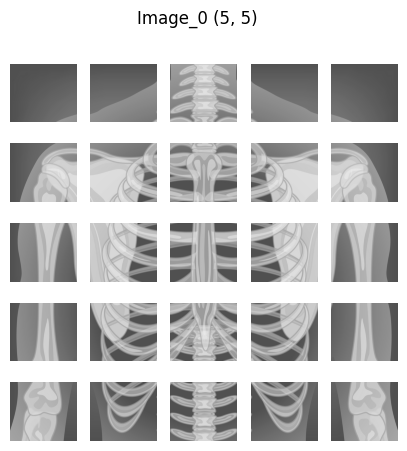

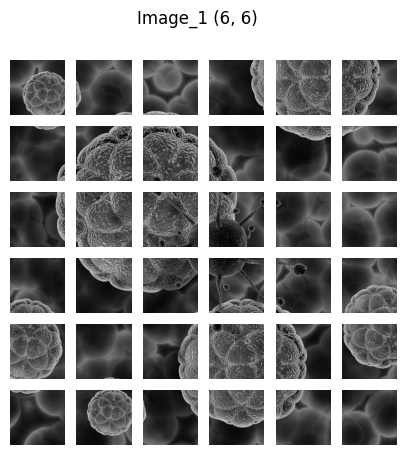

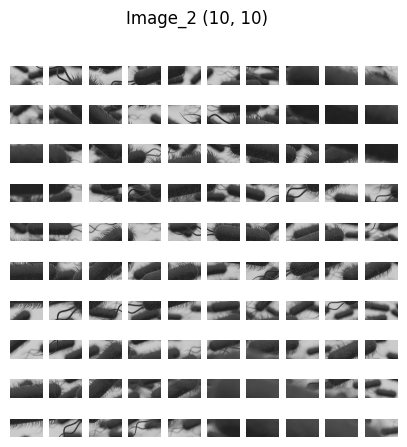

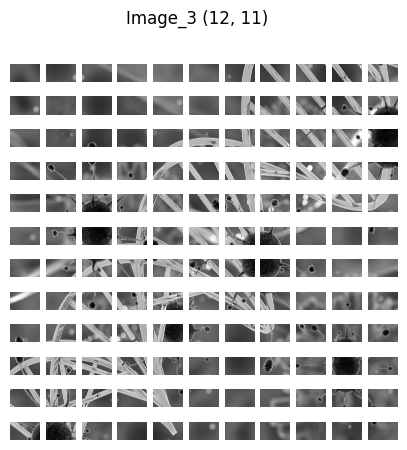

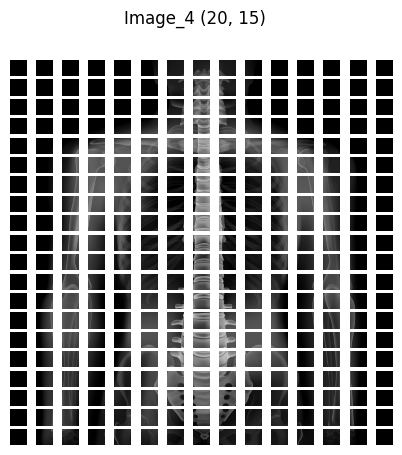

In [37]:

def visualize_patches_with_dimensions(loaded_images, image_dimensions):
    for i, (image, (m, n)) in enumerate(zip(loaded_images, image_dimensions)):
        
        image_dir = os.path.join(results_dir, f"Image_{i}")
        if not os.path.exists(image_dir):
            os.makedirs(image_dir)

        height, width, _ = image.shape

       
        patch_height = height // m
        patch_width = width // n

       
        fig, axes = plt.subplots(m, n, figsize=(5, 5))

        for h in range(0, height - patch_height + 1, patch_height):
            for w in range(0, width - patch_width + 1, patch_width):
                patch = image[h:h + patch_height, w:w + patch_width] 

                patch_path = os.path.join(image_dir, f'patch_{h}_{w}.jpg') 
                cv.imwrite(patch_path, patch)

                ax = axes[h // patch_height, w // patch_width]
                ax.imshow(patch)
                ax.set_axis_off()

        
        plt.suptitle(f"Image_{i} {image_dimensions[i]}")
        plt.show()



visualize_patches_with_dimensions(loaded_images, image_dimensions)


### Histogram Calculation

In [ ]:

histogram_dict = {}
for i in range(5): 
    image_dir = os.path.join(results_dir, f"Image_{i}")
    patch_histograms = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):  
            patch = cv2.imread(os.path.join(image_dir, filename))
            hist = cv2.calcHist([patch], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
            patch_histograms.append(hist)
            del patch
            del hist
    histogram_dict[f"Image_{i}"] = patch_histograms

for key, value in histogram_dict.items():
    fig, axs = plt.subplots(len(value), 1, figsize=(8, 6 * len(value) // 10))
 
    fig.suptitle(f"{key} Histograms")

    for j, hist in enumerate(value):
        flattened_hist = hist.flatten()
        axs[j].plot(flattened_hist, label=f"Patch {j + 1} Histogram")
        axs[j].legend()
        axs[j].set_xlabel("Bins")
        axs[j].set_ylabel("Frequency")

    plt.savefig(f"{key}_histograms.png", dpi=300)
    plt.close()
   

### KMeans

In [38]:
k_value = 34  


def apply_kmeans_to_patches(loaded_images, k_value):
    for i, image in enumerate(loaded_images):
           
            pixels = image.reshape((-1, 3))
            kmeans = KMeans(n_clusters=k_value, random_state=0, n_init=10)  
            labels = kmeans.fit_predict(pixels)

            
            colors = np.random.randint(0, 256, size=(k_value, 3))  
            colored_image = np.zeros_like(image)
            for j in range(len(labels)):
                h, w = j // image.shape[1], j % image.shape[1]
                colored_image[h, w] = colors[labels[j] % k_value]

            
            image_dir = os.path.join(results_dir, f"Image_{i}")
            if not os.path.exists(image_dir):
                os.makedirs(image_dir)
            image_path = os.path.join(image_dir, f"result_{i}.jpg")
            cv2.imwrite(image_path, colored_image)

            
            print(f"Saved resulting image for Image_{i} at {image_path}")


apply_kmeans_to_patches(loaded_images, k_value)

Saved resulting image for Image_0 at Results\Image_0\result_0.jpg
Saved resulting image for Image_1 at Results\Image_1\result_1.jpg
Saved resulting image for Image_2 at Results\Image_2\result_2.jpg
Saved resulting image for Image_3 at Results\Image_3\result_3.jpg
Saved resulting image for Image_4 at Results\Image_4\result_4.jpg


### Mean-Shift

In [ ]:
def apply_mean_shift_to_patches(loaded_images):
    for i, image in enumerate(loaded_images):
        patches = []
        for h in range(0, image.shape[0], patch_height):
            for w in range(0, image.shape[1], patch_width):
                patch = image[h:h+patch_height, w:w+patch_width]
                patches.append(patch)

        reshaped_patches = np.array(patches).reshape(-1, patch_height * patch_width * 3)

        bandwidth = estimate_bandwidth(reshaped_patches, quantile=0.2, n_samples=500)

        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(reshaped_patches)
        labels = ms.labels_

        cluster_centers = ms.cluster_centers_

        clustered_patches = []
        for patch in patches:
            reshaped_patch = patch.reshape(-1, patch_height * patch_width * 3)
            labels = ms.predict(reshaped_patch)
            clustered_patch = cluster_centers[labels].reshape(patch.shape)
            clustered_patches.append(clustered_patch)

        cv2.imshow(f"Mean-Shift Clustering for Image_{i}", np.hstack(clustered_patches))

apply_mean_shift_to_patches(loaded_images)

### Active contour segmentation

In [44]:
def apply_active_contour_segmentation(Image):
    image = cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
    img = np.array(image, dtype=np.float64)

    IniLSF = np.ones((img.shape[0], img.shape[1]), img.dtype)
    IniLSF[30:80, 30:80] = -1
    IniLSF = -IniLSF

    Image = cv2.cvtColor(Image, cv2.COLOR_BGR2RGB)

    def mat_math(intput, str):
        output = intput
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if str == "atan":
                    output[i, j] = math.atan(intput[i, j])
                if str == "sqrt":
                    output[i, j] = math.sqrt(intput[i, j])
        return output

    def CV(LSF, img, mu, nu, epison, step):
        Drc = (epison / math.pi) / (epison * epison + LSF * LSF)
        Hea = 0.5 * (1 + (2 / math.pi) * mat_math(LSF / epison, "atan"))
        Iy, Ix = np.gradient(LSF)
        s = mat_math(Ix * Ix + Iy * Iy, "sqrt")
        Nx = Ix / (s + 0.000001)
        Ny = Iy / (s + 0.000001)
        Mxx, Nxx = np.gradient(Nx)
        Nyy, Myy = np.gradient(Ny)
        cur = Nxx + Nyy
        Length = nu * Drc * cur

        Lap = cv2.Laplacian(LSF, -1)
        Penalty = mu * (Lap - cur)

        s1 = Hea * img
        s2 = (1 - Hea) * img
        s3 = 1 - Hea
        C1 = s1.sum() / Hea.sum()
        C2 = s2.sum() / s3.sum()
        CVterm = Drc * (-1 * (img - C1) * (img - C1) + 1 * (img - C2) * (img - C2))

        LSF = LSF + step * (Length + Penalty + CVterm)
        return LSF

    mu = 1
    nu = 0.003 * 255 * 255
    num = 20
    epison = 1
    step = 0.1
    LSF = IniLSF
    for i in range(1, num):
        LSF = CV(LSF, img, mu, nu, epison, step)
        if i == num - 1:
            plt.imshow(Image), plt.xticks([]), plt.yticks([])
            plt.contour(LSF, [0], colors='r', linewidth=2)
            plt.show()

for image in loaded_images:
    apply_active_contour_segmentation(image)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Cr7th\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Cr7th\AppData\Local\Temp\ipykernel_20656\3538758528.py", line 60, in <module>
    apply_active_contour_segmentation(image)
  File "C:\Users\Cr7th\AppData\Local\Temp\ipykernel_20656\3538758528.py", line 53, in apply_active_contour_segmentation
    LSF = CV(LSF, img, mu, nu, epison, step)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Cr7th\AppData\Local\Temp\ipykernel_20656\3538758528.py", line 23, in CV
    Hea = 0.5 * (1 + (2 / math.pi) * mat_math(LSF / epison, "atan"))
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Cr7th\AppData\Local\Temp\ipykernel_20656\3538758528.py", line -1, in mat_math
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent c

### Super pixel segmentation

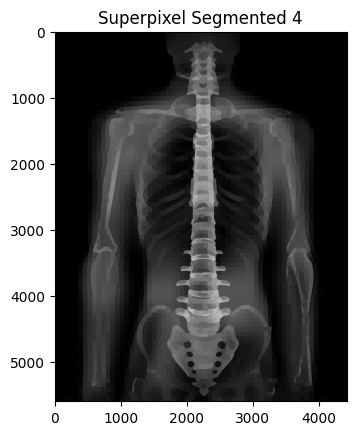

In [45]:

# Define the function for the mean image
def mean_image(image, label):
    img_reshape = image.reshape((image.shape[0]*image.shape[1], image.shape[2]))
    sli_1d = np.reshape(label, -1)
    uni = np.unique(sli_1d)
    uu = np.zeros(img_reshape.shape)
    for i in uni:
        loc = np.where(sli_1d == i)[0]
        mm = np.mean(img_reshape[loc, :], axis=0)
        uu[loc, :] = mm
    Superpixeled_Image = np.reshape(uu, [image.shape[0], image.shape[1], image.shape[2]]).astype('uint8')
    return Superpixeled_Image

# Define the function to apply k-means clustering to the image
def apply_kmeans_to_image(image, k_value):
    reshaped_image = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k_value, random_state=0, n_init=10)
    labels = kmeans.fit_predict(reshaped_image)
    cluster_centers = kmeans.cluster_centers_

    clustered_image = cluster_centers[labels].reshape(image.shape).astype('uint8')
    return clustered_image

# Display colored images after superpixel segmentation
for i, image in enumerate(loaded_images):
    label = slic(image, compactness=20, n_segments=5000)
    output = mean_image(image, label)  # display the output image.
    Generated_Image = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'generated_image_{i}.jpg', Generated_Image)

    def imshow(image, title=None):
        if len(image.shape) > 3:
            image = np.squeeze(image, axis=0)

        plt.imshow(image)
        if title:
            plt.title(title)

    generated_image = cv2.imread(f'generated_image_{i}.jpg')
    imshow(generated_image, f'Superpixel Segmented {i}')

### Otsu's thresholding

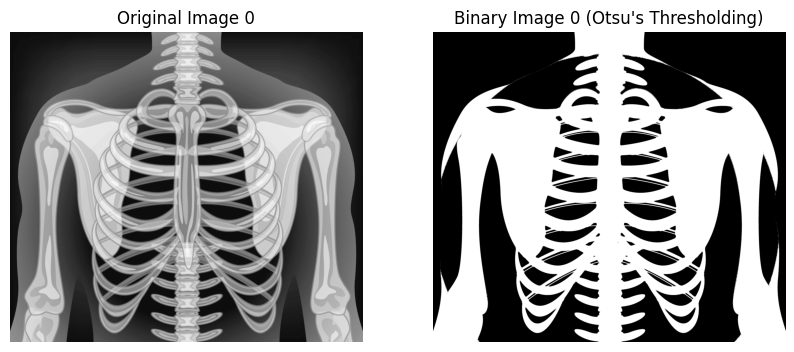

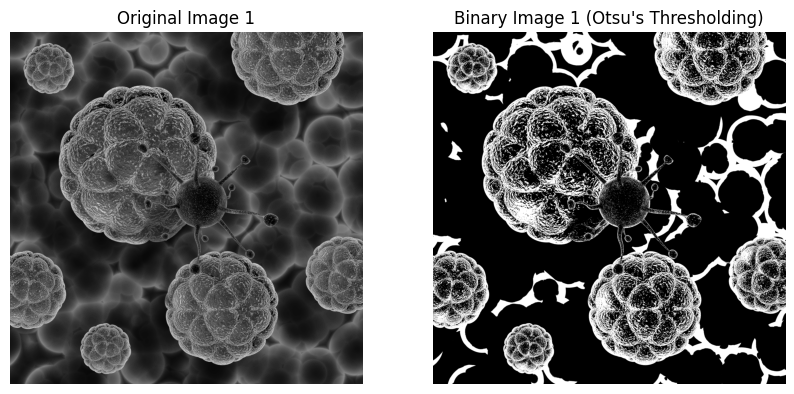

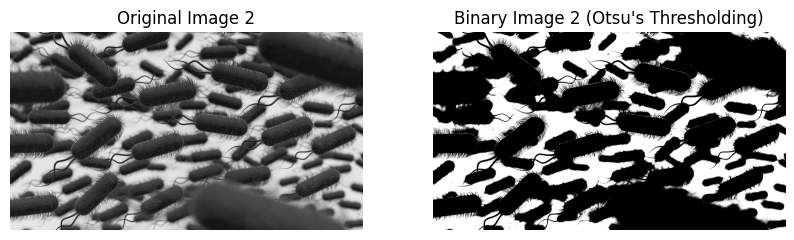

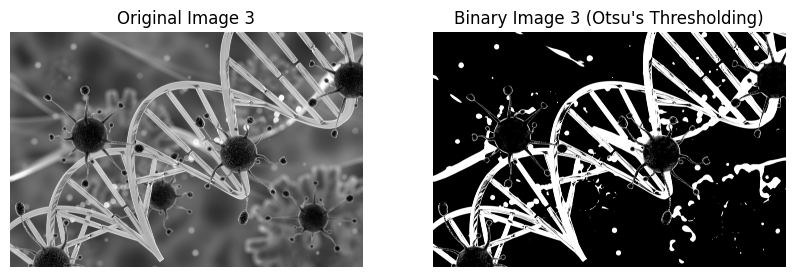

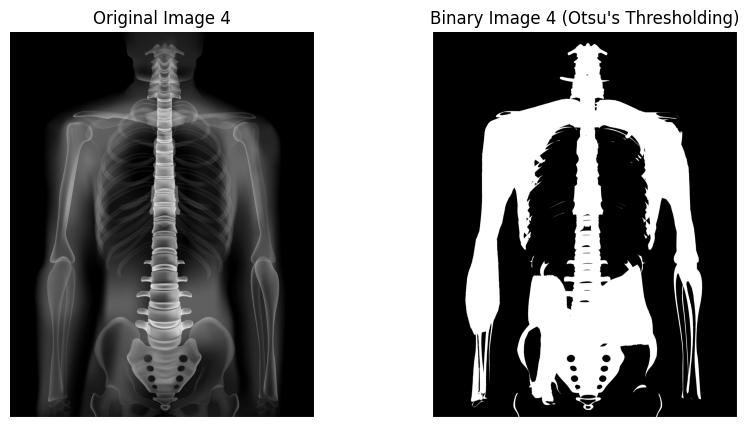

In [ ]:
Otsu_gray = []

for filename in os.listdir(image_dir):
    # Checking if the file is an image
    if filename.endswith(('.jpg')):
        file_path = os.path.join(image_dir, filename)
        image = cv.imread(file_path, cv.IMREAD_GRAYSCALE)  
        Otsu_gray.append(image)


for i, image in enumerate(Otsu_gray):
    _, binary_image = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'Original Image {i}')
    ax[0].axis('off')

    ax[1].imshow(binary_image, cmap='gray')
    ax[1].set_title(f'Binary Image {i} (Otsu\'s Thresholding)')
    ax[1].axis('off')

    plt.show()